<font color='#00AED3'>

# EduCreate | Minimum Viable Product </font>



# Setup and Import Modules

In [ ]:
%%capture
# Install required modules and packages
%pip install --upgrade --quiet langchain-community bs4 qdrant-client langchain-qdrant langchain-openai langchain wikipedia pymupdf openai langchain_huggingface easyocr
%pip install --upgrade --quiet diffusers transformers accelerate bitsandbytes peft
%pip install --quiet easyocr python-bidi==0.4.2

In [ ]:
# Import modules and packages
import torch
import os
import bs4
import json
import numpy as np
import math
import time
from pprint import pprint
import locale
import json
import re
import io
import requests
import IPython.display
import easyocr

from langchain import PromptTemplate

from langchain_core.prompts import ChatPromptTemplate

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_openai import ChatOpenAI

from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain_qdrant import Qdrant

from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel

from langchain_community.utils.math import cosine_similarity
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.document_loaders import TextLoader
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.document_loaders import OnlinePDFLoader
from langchain_community.document_loaders import PyMuPDFLoader

from langchain.schema import Document

from google.colab import userdata

from openai import OpenAI

from PIL import Image, ImageDraw, ImageFont
import textwrap

from diffusers import StableDiffusion3Pipeline
from transformers import T5EncoderModel, BitsAndBytesConfig


locale.getpreferredencoding = lambda: "UTF-8"

client = OpenAI(api_key = userdata.get("OPENAI_API_KEY_W210"))
openai_model = "gpt-4o-mini"

# Set seed for generator
seed = 1818
generator = torch.Generator("cuda").manual_seed(seed)

# Set configuration for quantization
quantization_config = BitsAndBytesConfig(load_in_8bit=True)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

<font color='#00AED3'>

# INPUT: User Requirements </font>

In [ ]:
## USER CHOICE ##

is_directed_content = False
is_directed_topic = True

is_load_pdf = False
is_load_image = False
is_load_text = False

## DIRECTED CONTENT ##

# 1. LOAD CONTENT
# Load PDF
load_pdf_path = '/content/Berlin_Crisis.pdf'

# Load Image
load_image_path = '/content/Civil_Rights_Movement_1.png'

# Enter text
# Source: https://www.history.com/topics/great-depression/1929-stock-market-crash
load_text = """
The Stock Market Crash of 1929 occurred on October 29, 1929, when Wall Street investors traded some 16 million shares on the New York Stock Exchange in a single day.
Billions of dollars were lost, wiping out thousands of investors. In the aftermath of that event, sometimes called “Black Tuesday,” America and the rest of the industrialized world spiraled downward into the Great Depression, the deepest and longest-lasting economic downturn in the history of the Western industrialized world up to that time.

During the 1920s, the U.S. stock market underwent rapid expansion, reaching its peak in August 1929 after a period of wild speculation in the Roaring Twenties. By then, production had already declined and unemployment had risen, leaving stocks in great excess of their real value.
Among the other causes of the stock market crash of 1929 were low wages, the proliferation of debt, a struggling agricultural sector and an excess of large bank loans that could not be liquidated.

Stock prices began to decline in September and early October 1929, and on October 18 a big drop in stock prices began. Panic soon set in, and on October 24, Black Thursday, a record 12,894,650 shares were traded. Investment companies and leading bankers attempted to stabilize the market by buying up great blocks of stock, producing a moderate rally on Friday.
On Monday, however, the storm broke anew, and the market went into free fall. Black Monday was followed by Black Tuesday—October 29, 1929—during which stock prices collapsed completely and 16,410,030 shares were traded on the New York Stock Exchange in a single day. Billions of dollars were lost, wiping out thousands of investors, and stock tickers ran hours behind because the machinery could not handle the tremendous volume of trading.

After October 29, 1929, stock prices had nowhere to go but up, so there was considerable recovery during succeeding weeks. Overall, however, prices continued to drop as the United States slumped into the Great Depression, and by 1932 stocks were worth only about 20 percent of their value in the summer of 1929.

The stock market crash of 1929 was not the sole cause of the Great Depression, but it did act to accelerate the global economic collapse which it was also a symptom. Stock prices continued to drop through 1932 when the Dow Jones Industrial Average—a widely-used benchmark for blue-chip stocks in the United States—closed at 41.22, its lowest value of the 20th century, 89 percent below its peak.
By 1933, nearly half of America’s banks had failed, and unemployment was approaching 15 million people or 30 percent of the U.S. workforce. The Dow Jones Industrial Average would not return to its pre-1929 heights until November of 1954, about 25 years later.

African Americans were particularly hard hit, as they were the “last hired, first fired.” Women during the Great Depression fared slightly better, as traditionally female jobs of the era like teaching and nursing were more insulated than those dependent on fluctuating markets.
Life for the average family during the Great Depression was difficult. Storms and a severe drought in the Southern Plains ruined crops, causing the area to be nicknamed the Dust Bowl. “Okies,” as fleeing residents were called, moved to big cities looking for work.
The relief and reform measures in the New Deal programs enacted by the administration of President Franklin D. Roosevelt helped lessen the worst effects of the Great Depression; however, the U.S. economy would not fully turn around until after 1939, when World War II revitalized American industry.
"""
# 2. ENTER INSTRUCTIONS
user_prompt_dc = """
Describe the Civil Rights Movement.
"""
# """What is the Berlin Crisis?"""
# """Write an account of the Stock Market Crash of 1929 from the perspective of a Wall Street trader working at the Wall Street Stock Exchange."""


## DIRECTED TOPIC ##
# 1. ENTER INSTRUCTIONS (WITHIN TOPICS COVERED)
user_prompt_dt = """
Describe the Civil Rights Movement.
"""
# """ What was the sequence of events when President John F Kennedy was notified on the U2 photographs? """

## STYLE CHOICE ##
# 1. CHOOSE STYLE

style_list = [
    {"Japanese Anime": {
        "prompt": "coloured anime artwork created by a Japanese anime studio, (Anime Style:1.3), (Manga Style:1.3), highly emotional, vibrant colors, best quality, high resolution",
        "negative_prompt": "speech bubbles, low resolution, bad anatomy, bad hands, text, errors, missing fingers, extra digits, cropped, worst quality, low quality, jpeg artifacts, signature, watermark, username, blurry"}
    },
    {"Disney Pixar": {
        "prompt": "vibrant Disney Pixar 3D style illustration, (Disney Pixar Style:1.3), motivational, vivid colors, sense of wonder, best quality, high resolution",
        "negative_prompt": "speech bubbles, low resolution, bad anatomy, bad hands, text, bad eyes, bad arms, bad legs, errors, missing fingers, extra digits, cropped, worst quality, low quality, jpeg artifacts, signature, watermark, blurry, grayscale, noisy, sloppy, messy, grainy, highly detailed, ultra-textured, photo"}
    },
    {"Western Comic": {
        "prompt": "coloured comic style with expressive characters and detailed backgrounds, (Comic Style:1.3), vibrant colors, dynamic poses, best quality, high resolution",
        "negative_prompt": "speech bubbles, photograph, deformed, glitch, noisy, realistic, stock photo, low resolution, bad anatomy, bad proportions, bad hands, text, errors, missing fingers, extra digits, cropped, worst quality, low quality, jpeg artifacts, signature, watermark, username, blurry"}
    },
    {"Toon": {
        "prompt": "vibrant and colorful toon-style illustration, (Toon Style:1.3), exaggerated features, playful characters, simplified shapes, bold outlines, high quality, high resolution",
        "negative_prompt": "low resolution, bad anatomy, bad hands, text, errors, missing fingers, extra digits, cropped, worst quality, low quality, jpeg artifacts, signature, watermark, username, blurry, realistic details, dark colors, serious expressions"}
    },
    {"Simpsons": {
        "prompt": "coloured illustration in the style of The Simpsons, characterized by exaggerated features, vibrant colors, and a cartoonish aesthetic. Characters with large eyes, overbites, and a humorous expression.",
        "negative_prompt": "realistic, highly detailed, photograph, 3D rendering, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry, grayscale, noisy, sloppy, messy, grainy"}
    }]

user_style = "Disney Pixar"

In [ ]:
# Inputs into the models based on user requirements
if is_directed_content:
  if is_load_pdf:
    load_doc = load_pdf_path
  if is_load_image:
    load_doc = load_image_path
  if is_load_text:
    load_doc = load_text
  user_prompt_pre = user_prompt_dc
else:
  user_prompt_pre = user_prompt_dt

# Improve user prompt with LLM
user_prompt_response = client.chat.completions.create(
    model=openai_model,
    messages=[
        {"role": "system", "content": "Improve the question or instruction prompt provided for the Retrieval-Augmented Generation model. The improved prompt should NOT EXCEED 50 words."},
        {"role": "user", "content": user_prompt_pre}])

user_prompt = user_prompt_response.choices[0].message.content

In [ ]:
# Inspect the original vs revised prompt
print("Original Prompt:")
pprint(user_prompt_pre.replace("\n", ""))
print("="*75)
print("Revised Prompt:")
pprint(user_prompt)

Original Prompt:
'Describe the Civil Rights Movement.'
Revised Prompt:
('Provide an overview of the Civil Rights Movement, highlighting its key '
 'events, figures, and goals. Include the historical context, major '
 'achievements, and its lasting impact on American society.')


# RAG Model

## Data Acquisition: Load & Chunk

In [ ]:
# List of Wikipedia webpages loaded for Directed Topic
wikipedia_queries = [
    "History",
    "Battle of Hastings",
    "Roman Empire",
    "Cold War",
    "Cuban Missile Crisis",
    "World War I",
    "World War II",
    "Great Depression"
    "American Civil War",
    "United States Declaration of Independence",
    "American Revolutionary War",
    "Civil rights movement"]

# List of webpage URLs loaded for Directed Topic
webpage_urls = [
    'https://history.state.gov/milestones/1961-1968/cuban-missile-crisis',
    'https://www.britannica.com/event/Cold-War',
    'https://www.history.com/news/cuban-missile-crisis-timeline-jfk-khrushchev',
    'https://history.state.gov/milestones/1914-1920/wwi',
    'https://history.state.gov/milestones/1776-1783/declaration']

In [ ]:
def load_chunk_wiki(query, global_doc_number, chunk_size=512, overlap=50):

  wiki_docs = WikipediaLoader(query=query, load_max_docs=4).load()

  for idx, text in enumerate(wiki_docs):
    wiki_docs[idx].metadata['doc_num'] = global_doc_number
    wiki_docs[idx].metadata['doc_source'] = "Wikipedia"

  global_doc_number += 1

  text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=overlap)
  wiki_splits = text_splitter.split_documents(wiki_docs)
  for idx, text in enumerate(wiki_splits):
    wiki_splits[idx].metadata['split_id'] = idx

  return wiki_splits, global_doc_number

def load_chunk_web(query, global_doc_number, chunk_size=512, overlap=50):

  web_docs = WebBaseLoader(query).load()

  for idx, text in enumerate(web_docs):
    web_docs[idx].metadata['doc_num'] = global_doc_number
    web_docs[idx].metadata['doc_source'] = "Webpage"

  global_doc_number += 1

  text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=overlap)
  web_splits = text_splitter.split_documents(web_docs)
  for idx, text in enumerate(web_splits):
    web_splits[idx].metadata['split_id'] = idx

  return web_splits, global_doc_number

def load_chunk_pdf(query, global_doc_number, chunk_size=512, overlap=50):

  pdf_docs = PyMuPDFLoader(query).load()

  for idx, text in enumerate(pdf_docs):
    pdf_docs[idx].metadata['doc_num'] = global_doc_number
    pdf_docs[idx].metadata['doc_source'] = "Loaded PDF"

  global_doc_number += 1

  text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=overlap)
  pdf_splits = text_splitter.split_documents(pdf_docs)
  for idx, text in enumerate(pdf_splits):
    pdf_splits[idx].metadata['split_id'] = idx

  return pdf_splits, global_doc_number

def load_chunk_text(query, global_doc_number, chunk_size=512, overlap=50):

  document = Document(page_content=query, metadata={'doc_num': global_doc_number, 'doc_source': "Loaded Text"})

  global_doc_number += 1

  text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=overlap)
  text_splits = text_splitter.split_documents([document])
  for idx, text in enumerate(text_splits):
    text_splits[idx].metadata['split_id'] = idx

  return text_splits, global_doc_number




## Base Embedding Model for RAG Pipeline

In [ ]:
%%capture
base_embeddings = HuggingFaceEmbeddings(model_name="avsolatorio/GIST-Embedding-v0")

## QDRANT Vector Store for RAG Pipeline

In [ ]:
%%capture
# Initialize vectorstore
wiki_splits_0, global_doc_number_0 = load_chunk_wiki(wikipedia_queries[0], global_doc_number=0)

qdrant_vectorstore = Qdrant.from_documents(wiki_splits_0,
                                           base_embeddings,
                                           location=":memory:",
                                           collection_name="history_db",
                                           force_recreate=True)

global_doc_number = global_doc_number_0

# Vectorize the Wikipedia chunks
if is_directed_topic:
  for wiki_query in wikipedia_queries[1:]:
    wiki_splits, global_doc_number = load_chunk_wiki(wiki_query, global_doc_number=global_doc_number)
    qdrant_vectorstore.add_documents(documents=wiki_splits)

# Vectorize the Webpage chunks
if is_directed_topic:
  web_splits, global_doc_number = load_chunk_web(webpage_urls, global_doc_number=global_doc_number)
  qdrant_vectorstore.add_documents(documents=web_splits)

In [ ]:
%%capture
# Vectorize the Text chunks
if is_directed_content and is_load_text:
  text_splits, global_doc_number = load_chunk_text(load_doc, global_doc_number=global_doc_number)
  qdrant_vectorstore.add_documents(documents=text_splits)

# Vectorize the PDF chunks
if is_directed_content and is_load_pdf:
  pdf_splits, global_doc_number = load_chunk_pdf(load_doc, global_doc_number=global_doc_number)
  qdrant_vectorstore.add_documents(documents=pdf_splits)

# Vectorize the Image chunks
if is_directed_content and is_load_image:
  image_reader = easyocr.Reader(["en"])
  image_results = image_reader.readtext(load_doc)
  image_text = " ".join(result[1] for result in image_results)
  image_splits, global_doc_number = load_chunk_text(image_text, global_doc_number=global_doc_number)
  qdrant_vectorstore.add_documents(documents=image_splits)

In [ ]:
# Create the retriever
retriever = qdrant_vectorstore.as_retriever(search_kwargs={"k": 8})

In [ ]:
# Testing the vectorstore setup
query = user_prompt
docs = qdrant_vectorstore.similarity_search_by_vector(base_embeddings.embed_query(query), k=8)

In [ ]:
for doc in docs:
  pprint(doc.page_content)
  print("="*75)

'=== Overview of the civil rights movement ==='
('The civil rights movement (1896–1954) was a long, primarily nonviolent '
 'action to bring full civil rights and equality under the law to all '
 'Americans. The era has had a lasting impact on American society – in its '
 'tactics, the increased social and legal acceptance of civil rights, and in '
 'its exposure of the prevalence and cost of racism.')
('marked significant milestones in ending legalized segregation and '
 'institutionalized racism. The Civil Rights Movement laid the groundwork for '
 'subsequent social justice movements, shaping the national dialogue on '
 'equality, civil liberties, and the ongoing pursuit of a more just and '
 'inclusive society.')
('This is a timeline of the civil rights movement in the United States, a '
 'nonviolent mid-20th century freedom movement to gain legal equality and the '
 'enforcement of constitutional rights for people of color. The goals of the '
 'movement included securing equal pro

## Running the RAG Model

### Format / Parser Functions for RAG Pipeline

In [ ]:
# Create function that formats a list of documents into a single string
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [ ]:
# Use Langchain parser for LLM output
output_parser = StrOutputParser()

In [ ]:
# Setup LLM
openai_chat_model = ChatOpenAI(api_key=userdata.get("OPENAI_API_KEY_W210"),
                               model=openai_model,
                               max_tokens=None,
                               timeout=None,
                               temperature=0.6,
                               max_retries=2)

### Build RAG Pipeline

In [ ]:
# RAG template and prompt
summ_rag_template = """You are an expert in a broad range of History topics.
                       History teachers will be asking questions or provide instructions about a specific topic to help prepare classroom materials.
                       Provide detailed response for the question or instructions catering to the high school students audience.

                       Please respond to the question or instruction below based on the context information provided.
                       JUST ANSWER the question or instruction. DO NOT ADD replies such as 'Of Course!', 'Certainly' etc.
                       You may add factual information from your corpus of knowledge BUT ensure the additional information is factual.
                       \n\nHere are the topics and context:\n{context} \n\nHere is a question: \n{question}."""

summ_rag_prompt = ChatPromptTemplate.from_template(summ_rag_template)

In [ ]:
# Create RAG Chain for OpenAI
rag_chain = (
    {"context": retriever | format_docs,
     "question": RunnablePassthrough()}
    | summ_rag_prompt
    | openai_chat_model
    | output_parser
)

### RAG Output

In [ ]:
summ_response = rag_chain.invoke(user_prompt_pre)
pprint(summ_response)

('The Civil Rights Movement was a pivotal social movement in the United States '
 'that aimed to end racial segregation, discrimination, and disenfranchisement '
 'of African Americans, primarily between 1954 and 1968. It sought to achieve '
 'legal equality and enforce constitutional rights for people of color, '
 'addressing issues such as access to public facilities, education reform, '
 'fair housing, and voting rights.\n'
 '\n'
 'The movement emerged from a long history of struggle against racial '
 'injustice, with its roots tracing back to the Reconstruction era and gaining '
 'momentum in the 1940s. It was characterized by a commitment to nonviolent '
 'resistance and civil disobedience, inspired by figures like Mohandas Gandhi '
 'and the teachings of Christianity, particularly the Sermon on the Mount.\n'
 '\n'
 'Key events in the movement included the Montgomery Bus Boycott (1955-1956), '
 "sparked by Rosa Parks' refusal to give up her seat to a white passenger; the "
 'Birmi

In [ ]:
system_content = """
You are a prolific comic script writer and a computer vision guru.
You will be given a historical account and you need to turn that into a comic script that will be used to prompt image generation to create the comic.

READ the instructions LINE BY LINE below.

Your response will have 4 components as follows:
1. "character": Provide description of the character including clothing and facial features, or NAME if it is a well known character. DO NOT EXCEED 7 WORDS.
2. "context": Provide description of the scene and historical setting. DO NOT EXCEED 5 WORDS.
3. "script": Provide a LIST that sets out each script sequence IN DETAIL. USE {character} ONLY when referring to the "character" in the script.
4. "caption": Provide a LIST of historical DETAILED descriptions for each script sequence. The number of captions should EQUAL the number of script sequence. Ensure the length of the captions are sufficiently long to be meaningful. DO NOT USE {character} as reference in the captions.
5. "title": Provide a title for the script.

Your response should be in the following DICTIONARY format:
{"character": '...', "context": '...', "script": ['...','...',...], "caption": ['...','...',...], "title": '...'}

Here is an example of what your response should look like:
{"character": 'a middle aged Wall Street trader wearing a blue suit with slicked hair called John', "context": 'the year is 1929 with a scene in New York Stock Exchange', "script": ['{character} frantically shouting orders on the crowded trading floor, surrounded by panicked traders and falling stock prices', '{character} staring at the stock ticker in disbelief as the numbers plummet rapidly, signaling the crash.'], "caption": ['1. The New York Stock Exchange is a frenzy of activity as traders like John try to salvage their investments amidst the chaos of falling stock prices.', '2. Numbers on the stock ticker flash red as John watches in shock and horror at the speed of the market crash unfolding before his eyes.'], "title": 'Black Tuesday'}
"""

user_content = """
The year for 1962 at the height of the Cold War. The world was at its closest to a nuclear war that would be disasterous for all countries.
President John F Kennedy just received news from his advisers that missiles sites have been discovered in Cuba. He needs to decide the next course of actions.
He is presented with several options and he needs to consider each one carefully. Finally, he decided Blockade is the best option and it turns out to be a great decision.
"""

assistant_content = """
{"character": "President John F Kennedy, a young 45 year old gentlemen, wearing a smart dark blue suit, with black hair, blue eyes and slick hair.",
"context": "Time period is 1960s in the United States of America.",
"script": ["{character} is sitting in the Oval office with his assistant standing next to him briefing him on a report.",
           "{character} is holding a meeting with his advisers on a long table in a meeting room. The advisers are sat opposite each other on the long table.",
           "{character} points to a paper report on the table as he addresses his advisers. The paper report contains information about missile sites in Cuba.",
           "{character} watched his advisers arguing angrily with each other about what {character} should do.",
           "{character} sits in a leather sofa in the Oval office thinking hard about the next steps. There are different options swirling in his mind.",
           "{character} makes an announcement on a Presidential podium to a room full of reporters that there will be a Cuban blockade."],
"caption": ["1. President John F Kennedy receives a report from his adviser that missile sites have been found in Cuba. The year was 1962.",
            "2. He called for a meeting with advisers to discuss what to do next. On one side he has the 'Doves' and on the other he has the 'Hawks'.",
            "3. President John F Kennedy: Gentlemen! The hour is upon us. Here is the report I received about Fidel Castro and the agreement with the Soviet Union to place nuclear missiles within attacking distance of the United States.",
            "4. The advisers argued about what should be done. Seven different options were laid on the table.",
            "5. President John F Kennedy thought to himself about what he should do next. The next move will change the course of history.",
            "6. After much deliberation, he set Robert Kennedy to strike a deal with Khrushchev. In the mean time, he announced to the world that a blockade will be introduced."],
"title": "JFK and the Cuban Missile Crisis"}
"""

image_response = client.chat.completions.create(
    model=openai_model,
    messages=[
        {"role": "system", "content": system_content},
        {"role": "user", "content": user_content},
        {"role": "assistant", "content": assistant_content},
        {"role": "user", "content": summ_response}
        ]
)

In [ ]:
rag_results = json.loads(image_response.choices[0].message.content)
print("Initial RAG Results:")
display(rag_results)

Initial RAG Results:


{'character': 'Martin Luther King Jr., an African American man wearing a black suit and tie with a confident expression.',
 'context': 'American South during the Civil Rights Movement.',
 'script': ['{character} stands at the Lincoln Memorial, addressing a large crowd during the March on Washington, passionately speaking about his dream of equality and justice.',
  '{character} is shown at a church meeting, standing at a pulpit, encouraging activists to engage in nonviolent protests.',
  "{character} is walking with a group of demonstrators on a sidewalk, holding a sign that reads 'Equal Rights for All'.",
  '{character} is sitting at a table with other leaders, discussing strategies to combat segregation and discrimination.',
  '{character} addresses a group of young people, inspiring them to join the movement and fight for their rights.',
  '{character} watches as news reports cover the violent reactions of segregationists to peaceful protests in Birmingham.'],
 'caption': ["1. A sea

In [ ]:
# Initialize the final results dictionary
rag_results_final = rag_results.copy()
rag_results_final['caption'] = []

# Loop through the captions and modify if necessary
for cap in rag_results['caption']:
  if '{character}' in cap:
    # Generate the revised caption
    rag_result_revision = client.chat.completions.create(
        model=openai_model,
        messages=[
            {"role": "system", "content": "Improve the generated comic caption so that it is NOT referring to {character}."},
            {"role": "user", "content": cap}
            ])
    # Add the revised caption to the final results
    revised_caption = rag_result_revision.choices[0].message.content
    rag_results_final['caption'].append(revised_caption)
  else:
    # Add the original caption to the final results
    rag_results_final['caption'].append(cap)

# Display the final results
print("Final RAG Results:")
display(rag_results_final)

Final RAG Results:


{'character': 'Martin Luther King Jr., an African American man wearing a black suit and tie with a confident expression.',
 'context': 'American South during the Civil Rights Movement.',
 'script': ['{character} stands at the Lincoln Memorial, addressing a large crowd during the March on Washington, passionately speaking about his dream of equality and justice.',
  '{character} is shown at a church meeting, standing at a pulpit, encouraging activists to engage in nonviolent protests.',
  "{character} is walking with a group of demonstrators on a sidewalk, holding a sign that reads 'Equal Rights for All'.",
  '{character} is sitting at a table with other leaders, discussing strategies to combat segregation and discrimination.',
  '{character} addresses a group of young people, inspiring them to join the movement and fight for their rights.',
  '{character} watches as news reports cover the violent reactions of segregationists to peaceful protests in Birmingham.'],
 'caption': ["1. A sea

# Text2Image Model | Stable Diffusion 3

## Combine Prompts

In [ ]:
user_style_choice = next((style for style in style_list if user_style in style), None)

# STYLE prompt
style_prompt = user_style_choice[user_style]["prompt"]

# CHARACTER prompt
character_prompt = rag_results_final["character"]

# CONTEXT prompt
context_prompt = rag_results_final["context"]

# EACH COMIC PANEL prompt
story_prompt = rag_results_final["script"]

# Create CAPTIONS for each comic panel
captions = rag_results_final["caption"]

# NEGATIVE prompt
negative_prompt = user_style_choice[user_style]["negative_prompt"]

In [ ]:
# Combine the style, character, context and story prompts
combined_prompt = []

for story in story_prompt:
  comb_prom = context_prompt + "; " + story.replace("{character}", character_prompt) + "; " + style_prompt
  combined_prompt.append(comb_prom)

# Print combined prompts
for prompt in combined_prompt:
  pprint(prompt)

('American South during the Civil Rights Movement.; Martin Luther King Jr., an '
 'African American man wearing a black suit and tie with a confident '
 'expression. stands at the Lincoln Memorial, addressing a large crowd during '
 'the March on Washington, passionately speaking about his dream of equality '
 'and justice.; vibrant Disney Pixar 3D style illustration, (Disney Pixar '
 'Style:1.3), motivational, vivid colors, sense of wonder, best quality, high '
 'resolution')
('American South during the Civil Rights Movement.; Martin Luther King Jr., an '
 'African American man wearing a black suit and tie with a confident '
 'expression. is shown at a church meeting, standing at a pulpit, encouraging '
 'activists to engage in nonviolent protests.; vibrant Disney Pixar 3D style '
 'illustration, (Disney Pixar Style:1.3), motivational, vivid colors, sense of '
 'wonder, best quality, high resolution')
('American South during the Civil Rights Movement.; Martin Luther King Jr., an '
 'A

In [ ]:
# Reference: https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_3

# Function to create Stable Diffusion 3 pipeline
def create_sd3_pipeline():
  model_id = "stabilityai/stable-diffusion-3-medium-diffusers"
  text_encoder = T5EncoderModel.from_pretrained(model_id,
                                                subfolder="text_encoder_3",
                                                quantization_config=quantization_config)
  pipe = StableDiffusion3Pipeline.from_pretrained(model_id,
                                                  text_encoder_3=text_encoder,
                                                  device_map="balanced",
                                                  torch_dtype=torch.float16)
  torch.cuda.empty_cache()
  return pipe

# Function to generate image from Stable Diffusion
def generate_image_sd3(pipe, prompt, negative_prompt, generator):
  image = pipe(
      prompt=prompt,
      negative_prompt=negative_prompt,
      num_inference_steps=50,
      height=1024,
      width=1024,
      guidance_scale=7.0,
      generator=generator).images[0]

  return image

text_encoder_3/config.json:   0%|          | 0.00/740 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


(…)t_encoder_3/model.safetensors.index.json:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.53G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/247M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

tokenizer_3/special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer_3/tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_3/tokenizer_config.json:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

transformer/config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/739 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/4.17G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
Token indices sequence length is longer than the specified maximum sequence length for this model (87 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', sense of wonder, best quality, high resolution']
Token indices sequence length is longer than the specified maximum sequence length for this model (87 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', sense of wonder, best quality, high resolution']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', best quality, high resolution']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', best quality, high resolution']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['wonder, best quality, high resolution']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['wonder, best quality, high resolution']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['resolution']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['resolution']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', high resolution']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', high resolution']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['high resolution']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['high resolution']


  0%|          | 0/50 [00:00<?, ?it/s]

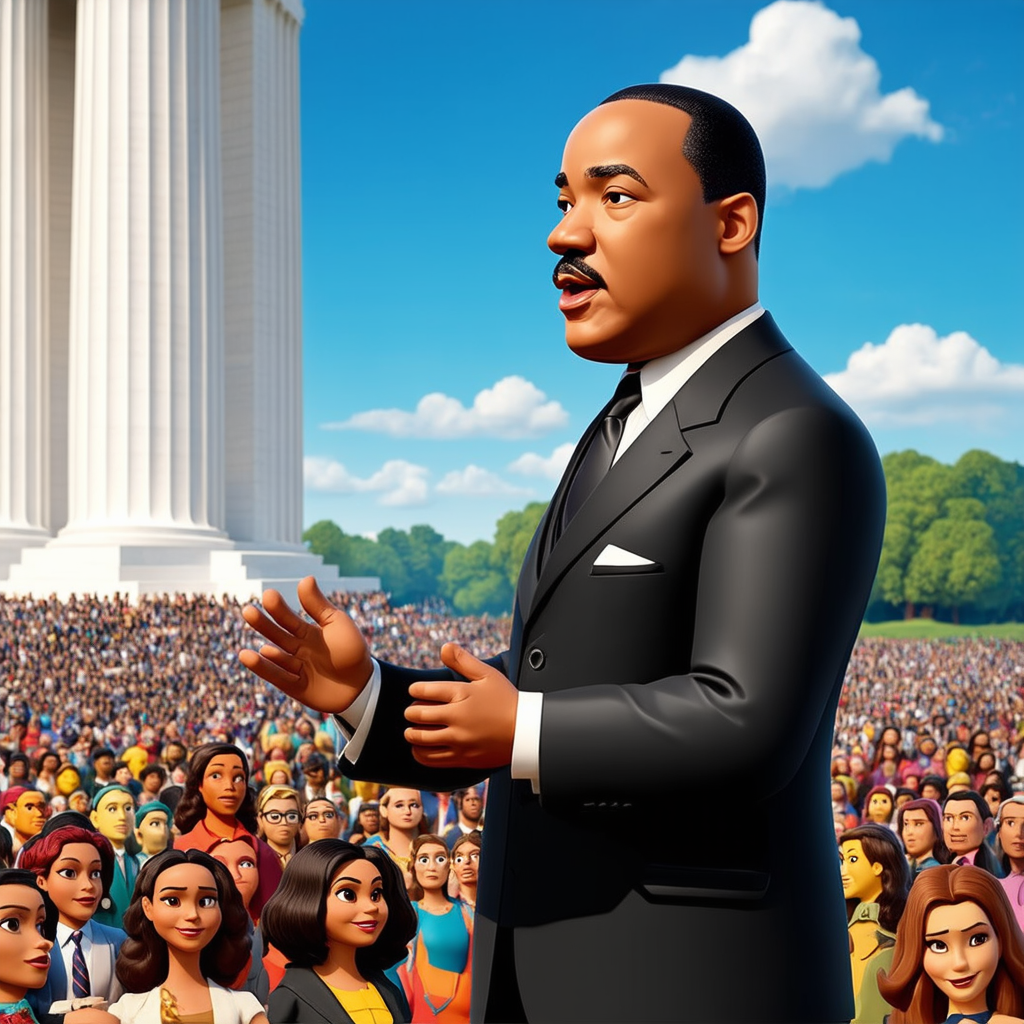

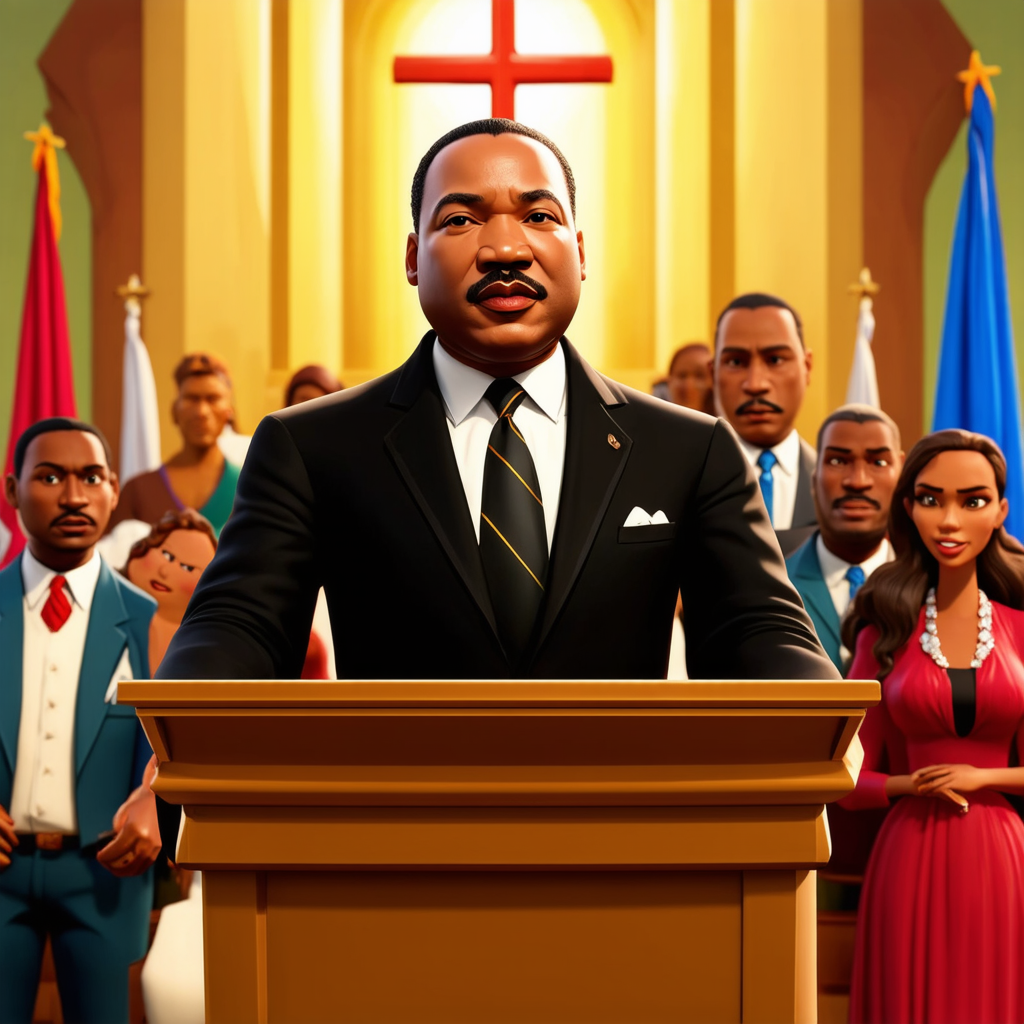

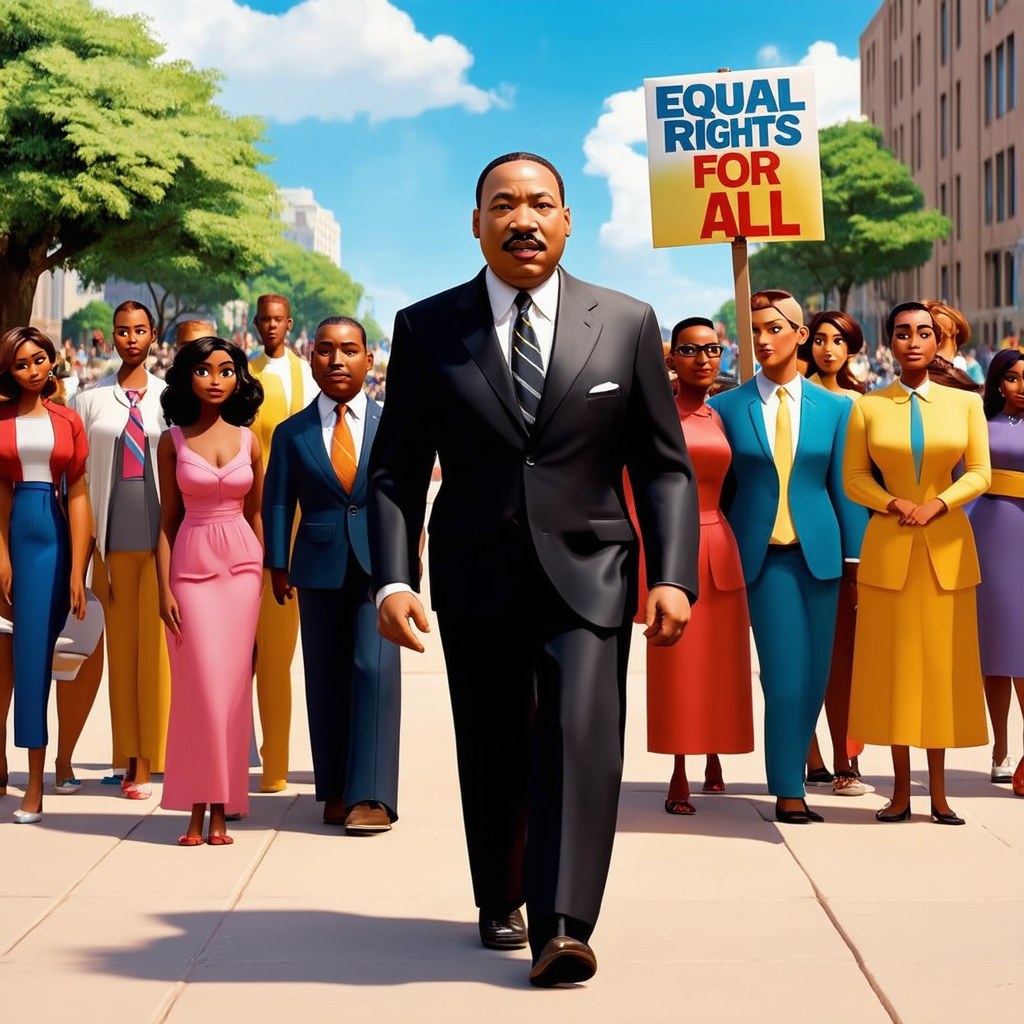

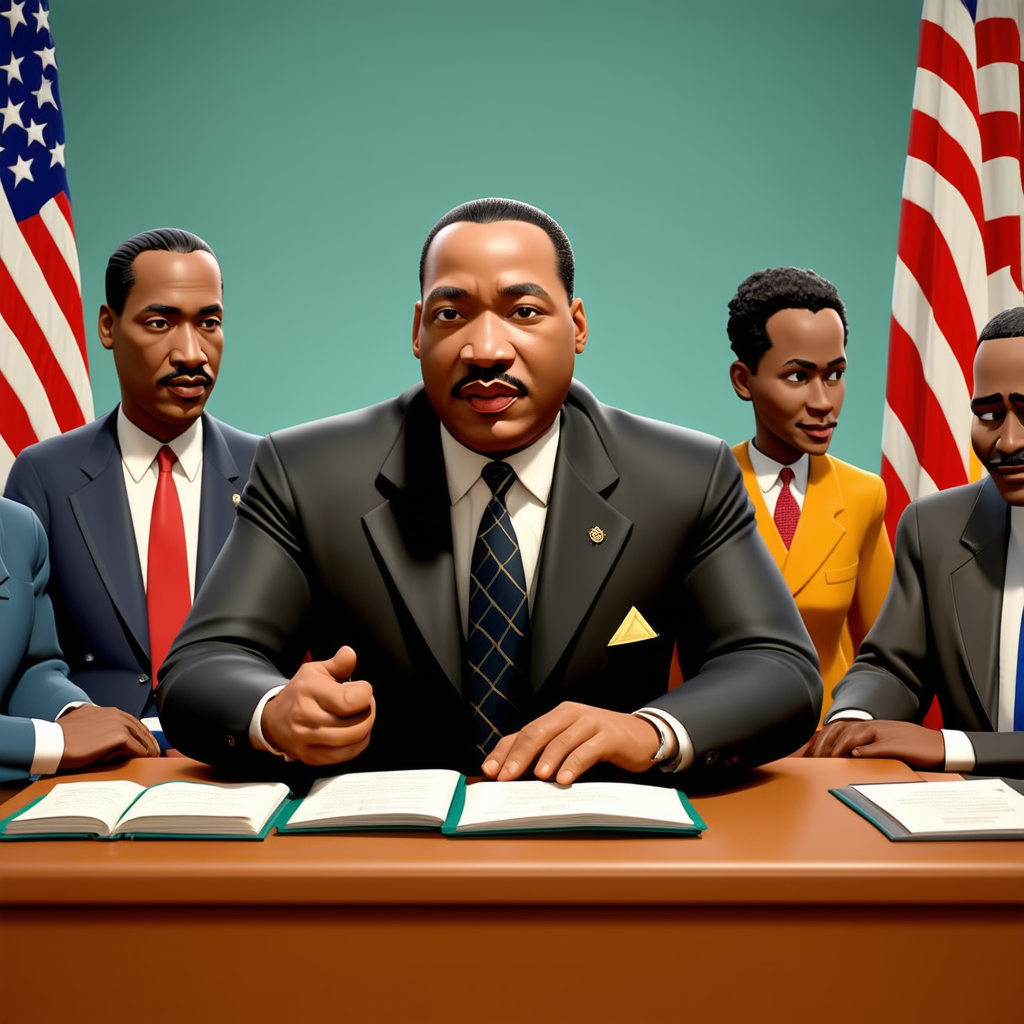

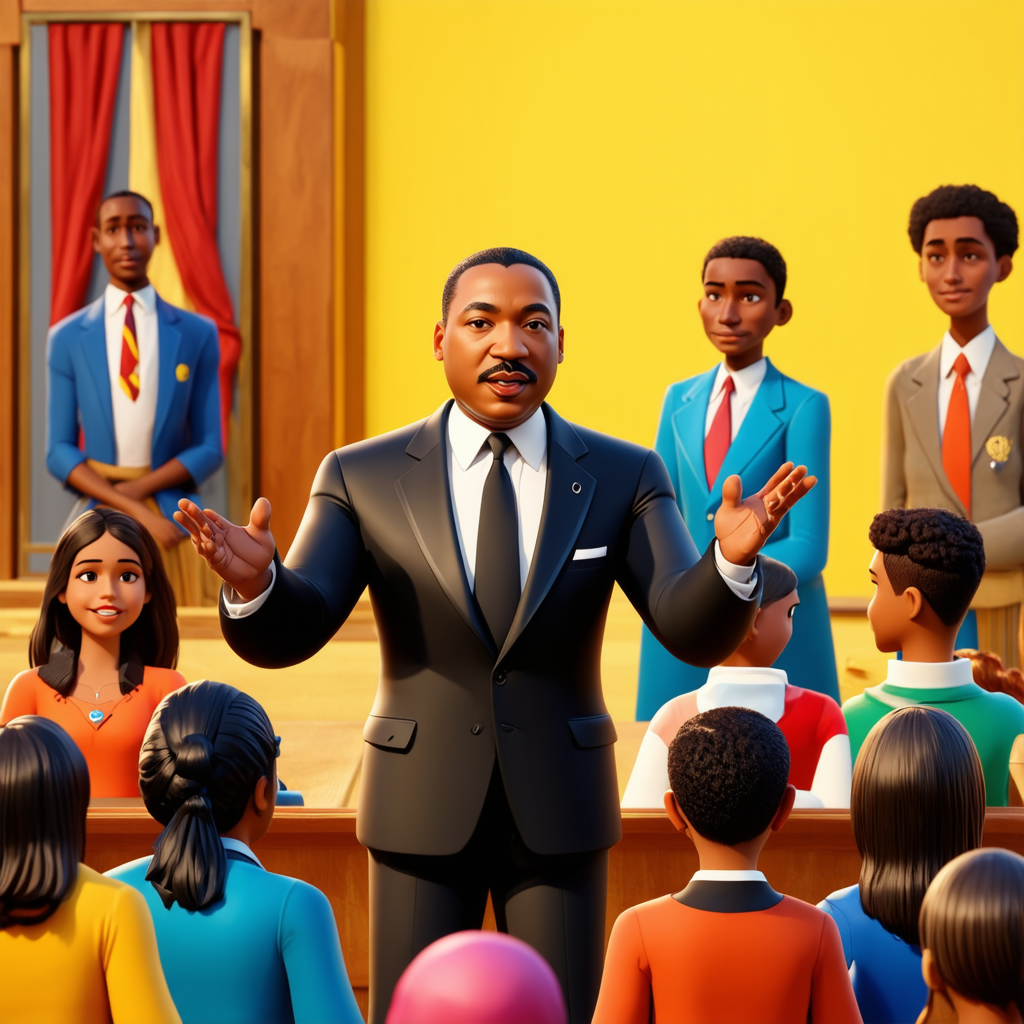

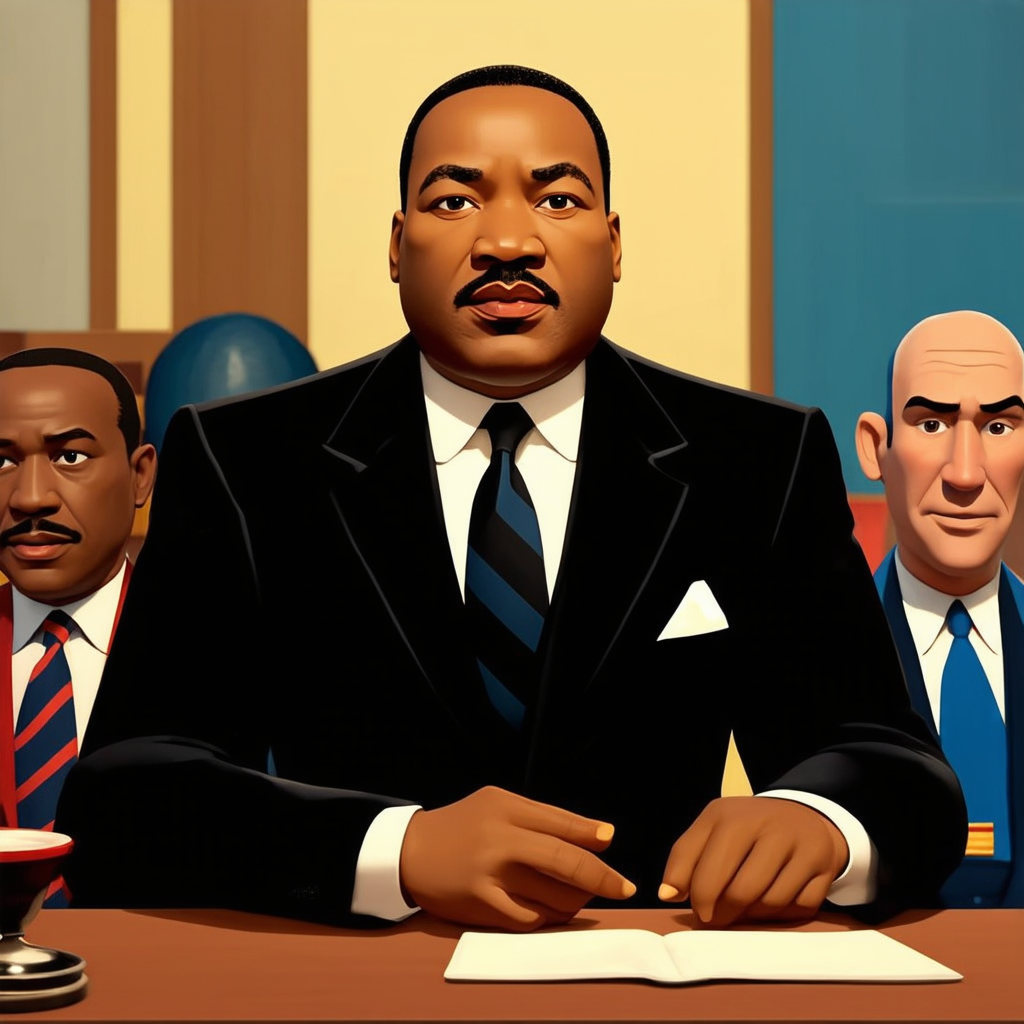

In [ ]:
comic_images = []

pipe = create_sd3_pipeline()
for prompt in combined_prompt:
  image = generate_image_sd3(pipe, prompt, negative_prompt, generator)
  comic_images.append(image)
  torch.cuda.empty_cache()

for image in comic_images:
  display(image)

In [ ]:
def create_comic_strip(images, texts, output_path,
                       image_width, image_height,
                       panels_horizontal, panels_vertical,
                       border_size=10, text_height=150,
                       font_path=None, font_size=30,
                       max_caption=45):
    """
    Organize images into a comic strip with borders and text boxes.

    Arguments:
    images: List of image file paths
    texts: List of text descriptions for each panel
    output_path: Path to save the final comic strip
    image_width: Width of each image
    image_height: Height of each image
    panels_horizontal: Number of panels placed horizontally
    panels_vertical: Number of panels placed vertically
    border_size: Size of the border around each panel
    text_height: Height of the text box at the bottom of each panel
    font_path: Path to the font file for the text
    font_size: Font size for the text
    max_captions: Maximum number of words in a caption
    """
    # Ensure the number of images matches the number of panels
    num_panels = panels_horizontal * panels_vertical
    if len(images) != num_panels:
        raise ValueError(f"The number of images ({len(images)}) does not match the total number of panels ({num_panels})")

    # Ensure the number of texts matches the number of panels
    if len(texts) != num_panels:
        raise ValueError(f"The number of texts ({len(texts)}) does not match the total number of panels ({num_panels})")

    # Check highest number of words in the captions
    caption_word_counts = []
    for caption in texts:
      caption_words = caption.split()
      word_caption_count = len(caption_words)
      caption_word_counts.append(word_caption_count)

    max_caption_word = max(caption_word_counts)

    # Determine text box size
    mult_standard_text_box = math.ceil(2 * max_caption_word / max_caption) / 2
    text_height = math.ceil(mult_standard_text_box * text_height)

    # Calculate total dimensions of the comic strip
    total_width = (image_width + 2 * border_size) * panels_horizontal
    total_height = (image_height + 2 * border_size + text_height) * panels_vertical

    # Create a new image with the total dimensions
    new_image = Image.new('RGB', (total_width, total_height), 'white')

    # Load the font
    font = ImageFont.truetype(font_path, size=font_size) if font_path else ImageFont.load_default()

    # Paste images into the new image
    for i, (image, text) in enumerate(zip(images, texts)):
        image = image.resize((image_width, image_height))

        # Create a panel with a border
        panel = Image.new('RGB', (image_width + 2 * border_size, image_height + 2 * border_size + text_height), 'white')
        panel.paste(image, (border_size, border_size))

        # Draw the text box
        draw = ImageDraw.Draw(panel)
        text_position = (border_size, image_height + 2 * border_size)
        draw.rectangle([text_position, (panel.width - border_size, panel.height - border_size)], fill="white")

        # Wrap the text to fit within the text box
        wrapped_text = textwrap.fill(text, width=(image_width // font_size * 2))

        # Add the text to the text box
        draw.text((text_position[0] + 10, text_position[1] + 10), wrapped_text, font=font, fill="black")

        # Calculate position in the new image
        x_offset = (i % panels_horizontal) * (image_width + 2 * border_size)
        y_offset = (i // panels_horizontal) * (image_height + 2 * border_size + text_height)
        new_image.paste(panel, (x_offset, y_offset))

    # Save the new comic strip image
    new_image.save(output_path)

In [ ]:
# Generate comic strip
ec_path = "/content/educreate.png"
ec_logo = Image.open(ec_path).convert("RGB")

if len(comic_images) % 2 == 1:
  comic_images.append(ec_logo)
  captions.append("")

output_path = 'comic_strip.png'
image_width = 1024
image_height = 1024
panels_horizontal = len(comic_images)//2
panels_vertical = 2
border_size = 10
text_height = 150
font_path = '/content/ComicNeue-BoldItalic.ttf'
font_size = 30
title = rag_results_final['title']

create_comic_strip(comic_images, captions, output_path, image_width, image_height, panels_horizontal, panels_vertical, border_size, text_height, font_path, font_size)